In [1]:
# Importing all the necessary libraries

import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from skimage.morphology import remove_small_holes,remove_small_objects,binary_closing,closing,convex_hull_image
from skimage.morphology import skeletonize, thin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder,MultiLabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import confusion_matrix,roc_auc_score,f1_score,classification_report
from scipy import stats
from imblearn.over_sampling import SMOTE 
import pandas as pd
import seaborn as sns
import os
from collections import Counter

In [2]:
def image_segmentation(img):
    
    # Transform the input image to YCbCr color space and calculate the histogram and its first derivative of cr-component 
    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    img_cr = img_ycrcb[:,:,1]       
    cr_hist,_ = np.histogram(img_cr.ravel(),256,[0,256])
    cr_hist_diff = np.diff(cr_hist)

    # Transform the input image to CIE-Lab color space and calculate the histogram and its first derivative of a-component 
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    img_a = img_lab[:,:,1]
    a_hist,_ = np.histogram(img_a.ravel(),256,[0,256])
    a_hist_diff = np.diff(a_hist)
    
    int_lvls = np.arange(0,255)
    
    # Calculating the segmentation threshold for cr-component based on its difference histogram
    
    # -18000 is the threshold of cr-component for (1200x900) image. So scaling the threshold as per input image dimensions
    cr_hist_th = int(-18000*(orig_img_shape[0]*orig_img_shape[1])/(1200*900))
    if (int_lvls[cr_hist_diff<=cr_hist_th].size!=0):
        cr_th_i = np.max(int_lvls[cr_hist_diff<=cr_hist_th])
    # If there is no pixel intensity below -18000, take threshold as peak of cr histogram
    else:
        cr_th_i = np.argmax(cr_hist)

    # Calculating the segmentation threshold for a-component based on its difference histogram
    
    # -1000 is the threshold of a-component for (1200x900) image. So scaling the threshold as per input image dimensions
    a_hist_th = int(-1000*(orig_img_shape[0]*orig_img_shape[1])/(1200*900))
    if (int_lvls[a_hist_diff<=a_hist_th].size!=0):
        a_th_i = np.max(int_lvls[a_hist_diff<=a_hist_th])
    # If there is no pixel intensity below -1000, take threshold as peak of a-histogram
    else:
        a_th_i = np.argmax(a_hist)

    
    # Thresholding the cr and a components using the above thresholds and calculating their segmented image outputs
    a_th = a_th_i
    cr_th = cr_th_i
    _, img_a_th = cv2.threshold(img_a, a_th, 255, cv2.THRESH_BINARY)
    _, img_cr_th = cv2.threshold(img_cr, cr_th, 255, cv2.THRESH_BINARY)
    
    # Performing logical AND between both the segmented images to get the final segmented image
    img_seg = cv2.bitwise_and(img_cr_th,img_a_th)
    #img = cv2.imread('/Users/barisx/test.jpg')
    #gray = cv2.cvtColor(img_seg, cv2.COLOR_BGR2GRAY)
    return img_seg

In [12]:
def image_postprocess(img_seg):
    
    # Removing small size artifacts on segmented image
    img_bin1 = (img_seg//255).astype(bool)
    img_rem1 = remove_small_objects(img_bin1,min_size=20,connectivity=8).astype('uint8')*255
    #img_fill = (remove_small_holes(img_rem1,area_threshold=5000,connectivity=8)).astype('uint8')*255
    #img_bin2 = (img_fill//255).astype(bool)
    #img_rem2 = remove_small_objects(img_bin2,min_size=50,connectivity=8).astype('uint8')*255
    #plt.imshow(img)
    #plt.title("normal")
    img_pp=img_rem1.copy()
    plt.imshow(img_pp)
    plt.title("mask")
    plt.show()
#     fig=plt.figure(figsize=(7,7))

#     normal_plot = fig.add_subplot(1,2,1)
#     plt.imshow(img,cmap='gray')
#     normal_plot.set_title('Normal')
#     plt.axis('off')

#     Tb_plot = fig.add_subplot(1,2,2)
#     plt.imshow(img_pp,cmap='gray')
#     normal_plot.set_title('mask')
#     plt.axis('off')
    
#     plt.cla()
    return img_pp

In [4]:
def label_image_objects(img_file,annot_fold_path):

    # Finding annotation file path from image file path
    annot_file = img_file[:-4]+'_annot.csv'
    annot_file_path = os.path.join(annot_fold_path,annot_file)

    annot_cols = ["Label","x_st_pt","y_st_pt","box_width","box_height","Image_name","Image_width","Image_height"]

    lbl_data = pd.read_csv(annot_file_path,names=annot_cols)
    #print(lbl_data)
    
    # Initializtion of labelled image with zero pixel intensities
    img_lbl = np.ones(orig_img_shape[:2], np.uint8)*20

    # Extracting the class label and drawing bounding boxes with different intensities on labelled image
    for i in range(lbl_data.shape[0]):
        x_st_pt = lbl_data["x_st_pt"][i]
        y_st_pt = lbl_data["y_st_pt"][i]
        x_end_pt = x_st_pt+lbl_data["box_width"][i]
        y_end_pt = y_st_pt+lbl_data["box_height"][i]
        if (lbl_data["Label"][i]=="circle"):
            fill_val = 50
        if (lbl_data["Label"][i]=="rectangle"):
            fill_val = 100
        if (lbl_data["Label"][i]=="rhombus"):
            fill_val = 150
        if (lbl_data["Label"][i]=="hexagon"):
            fill_val = 200
        st_pt = (x_st_pt,y_st_pt)
        end_pt = (x_end_pt,y_end_pt)
        cv2.rectangle(img_lbl, st_pt, end_pt, fill_val, thickness=-1)
    
    # Resize the labelled image to standard size of 600x800
    img_lbl = cv2.resize(img_lbl,(img_shape[1],img_shape[0]))
    
    # Perform logical AND between post processed image and labelled image to get postprocessed labelled image where each object
    # given different pixel intensities based on its class label
    img_pp_lbl = cv2.bitwise_and(img_pp,img_lbl)
    
    return img_lbl,img_pp_lbl

In [5]:
def find_contours(img_pp_lbl):
    
    # Find contours from the post processed labelled image
    contours,_ = cv2.findContours(img_pp_lbl, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
           
    # Threshold of contour area to accept or reject the contour
    area_th = 2000

    # Filtering the contours based on the number of contour points, contour area and its ellipse features
    contours_filt = []
    for cnt in contours:
        if (len(cnt)<5):
            continue
        (x,y),(ma,MA),angle = cv2.fitEllipse(cnt)
        area = cv2.contourArea(cnt)
        area_ell = np.pi*ma*MA/4
        if (x>img_shape[1] or x<0 or y>img_shape[0] or y<0 or area<5 or area>area_th):
            continue
        contours_filt.append(cnt)
        
    return contours_filt      

In [6]:
def extract_features(cnt):
    
    # Calculate eccentricity of contour by fitting an ellipse
    (x,y),(ma,MA),angle = cv2.fitEllipse(cnt)
    cnt_centre = (int(x),int(y))
    eccentricity = ma/MA
    
    # Contour perimeter
    perimeter = cv2.arcLength(cnt,True)
    
    # Contour area (in pixels)
    area = cv2.contourArea(cnt)
    
    # Convex hull of contour
    hull = cv2.convexHull(cnt)
    
    # Perimeter of convex hull
    perimeter_hull = cv2.arcLength(hull,True)
    
    # Roughness of contour
    roughness = perimeter/perimeter_hull
    
    # Area of convex hull
    area_hull = cv2.contourArea(hull)
    
    # Relative convex area
    rel_conv_area = area_hull/area
    
    # Circularity
    circularity = (4*np.pi*area)/perimeter**2
    #circularity = (4*np.pi*area)/perimeter_hull**2
    
    # Compactness
    compactness = perimeter**2/(4*np.pi*area)
    
    # Contour Area (in micro meter)
    area_um = area*2.2
    
    # Calculating Aspect ratio by fitting bounding box across the contour
    x,y,w,h = cv2.boundingRect(cnt)
    asp_ratio = w/h
    
    # Gathering all the features
    features = (cnt_centre,area,roughness,rel_conv_area,eccentricity,circularity,compactness,eccentricity)
    
    return features

In [7]:
def get_class_lbl(img_lbl,cnt_centre):
    if (img_lbl[cnt_centre[1],cnt_centre[0]]==50):
        cls_lbl = "1"
    elif (img_lbl[cnt_centre[1],cnt_centre[0]]==100):
        cls_lbl = "2"
    elif (img_lbl[cnt_centre[1],cnt_centre[0]]==20):
        cls_lbl = "3"
    else:
        cls_lbl = None
    
    return cls_lbl

In [8]:
def count_single_bacillus(cnt):
    
    # Initializing the count of single bacilli in a cluster to 0
    sing_tb_count = 0
    
    # Calculating the Polygon approximated (PA) contour to smoothen the irregularities
    cnt_approx = cv2.approxPolyDP(cnt,0.005*cv2.arcLength(cnt, True),True)
    
    # Calculating the convexhull of PA contour
    hull = cv2.convexHull(cnt_approx, returnPoints=False)
    hull[::-1].sort(axis=0)
    
    # Calculating the concave points using PA approximated contour and 
    defects = cv2.convexityDefects(cnt_approx, hull)
    #print(defects)
    
    # Calculating the contour segments between each pair of consecutive concave points
    if (defects is not None and defects.shape[0]>1):
        st_ind = -1
        #st_ind = 0
        for j in range(st_ind,defects.shape[0]-1):
            ind1 = defects[j,0,2]
            ind2 = defects[j+1,0,2]
            #print(ind1,ind2)
            if (ind1>ind2):
                list1 = list(range(ind1,cnt_approx.shape[0]))
                list2 = list(range(0,ind2+1))
                list_ = list1+list2
                #print(list_)
                cnt_temp1 = cnt_approx[list_]
            else:
                cnt_temp1 = cnt_approx[ind1:ind2+1]
            #print(cnt_temp1)
            img_temp = np.zeros(img_shape, np.uint8)
            img_temp = cv2.drawContours(img_temp, [cnt_temp1], -1, 255, 3)
            contours_temp,_ = cv2.findContours(img_temp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cnt_temp2 = contours_temp[0]
            
            # Fitting ellipse to each contour segment
            if (len(cnt_temp2)>=5):
                (x,y),(ma,MA),angle = cv2.fitEllipse(cnt_temp2)
                eccentricity = ma/MA
                area = cv2.contourArea(cnt_temp2)
                #print((eccentricity,area))
                if (eccentricity>0.1 and eccentricity<0.7 and area>50):
                    sing_tb_count+=1
                    
    return sing_tb_count,defects

In [9]:
cols_data = ['Area', 'Roughness','Relative convex area','Circularity','Compactness','Eccentricity','Class']
data = pd.DataFrame(columns = cols_data)

In [10]:
# Main Folder consisting of image data
main_fold = r"C:/Users/rkrao/OneDrive/Documents/tbbacillidataset/"

# Image subfolders
folders = ["Mannual_Microscope-2_set1","Mannual_Microscope-2_set2","Mannual_Seg_Microscope-1_set6","Mannual_Seg_Microscope-1_set7"]
# folders = ["Mannual_Microscope-2_set2"]

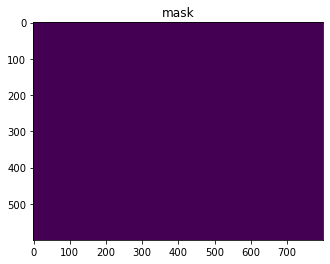

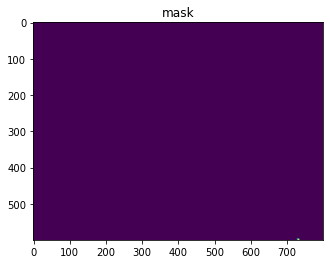

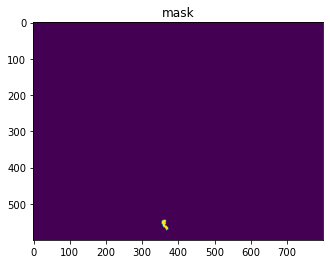

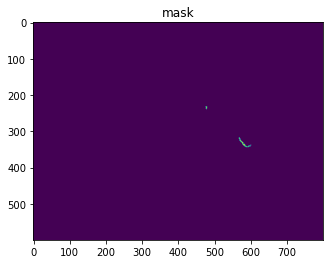

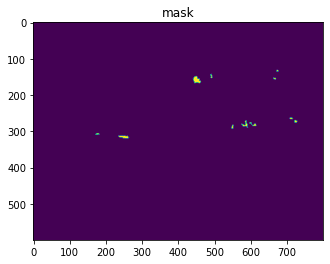

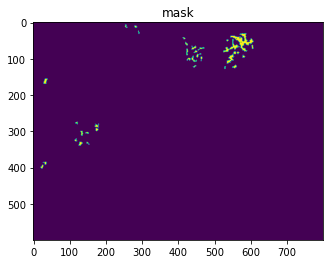

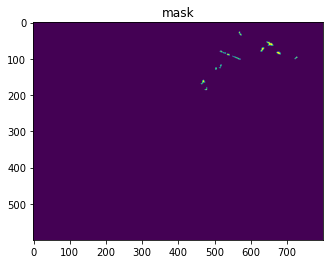

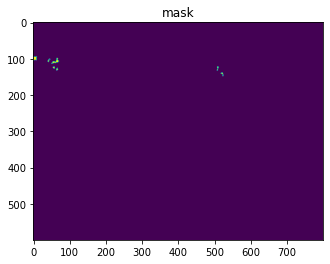

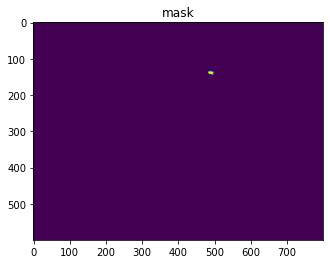

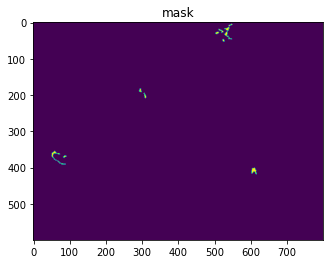

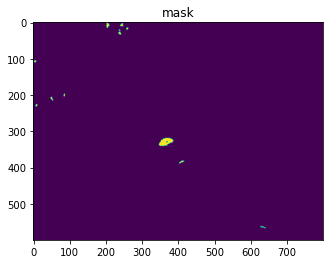

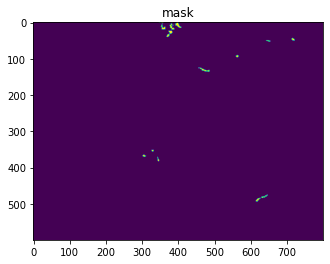

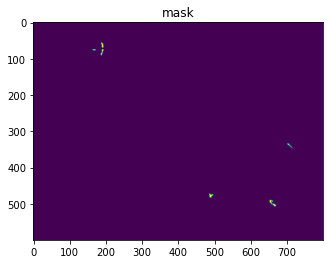

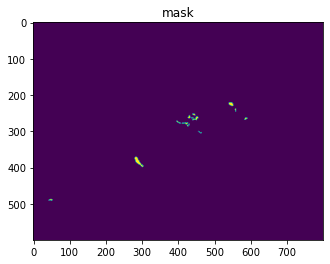

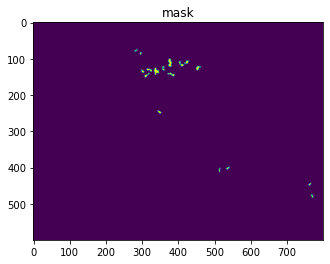

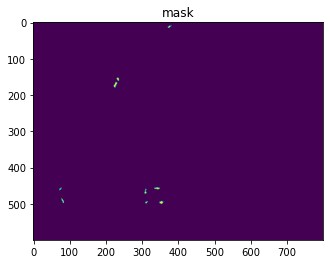

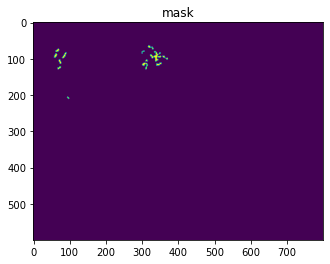

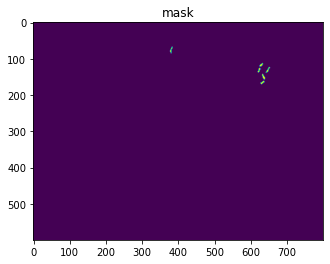

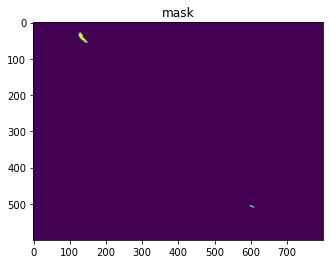

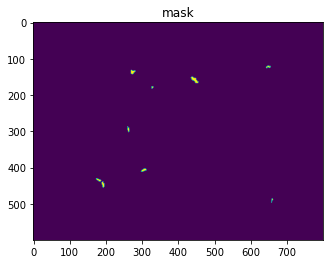

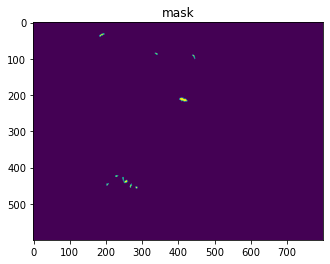

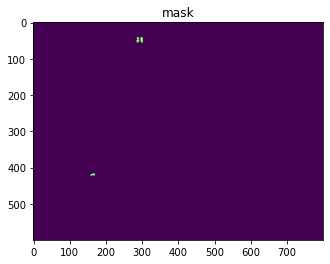

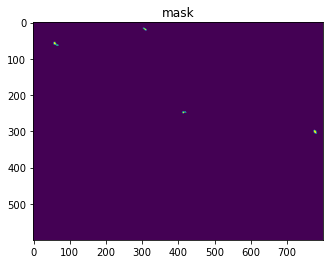

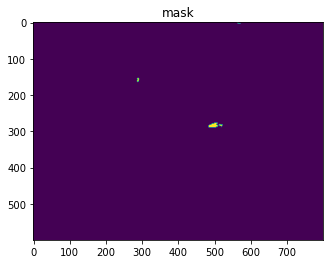

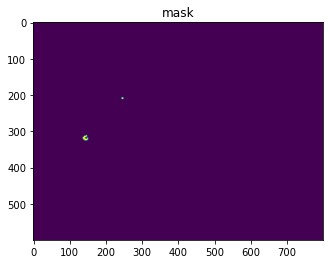

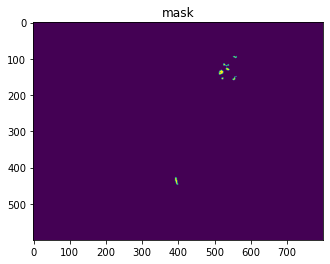

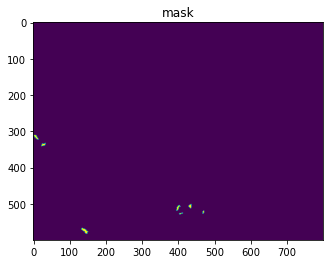

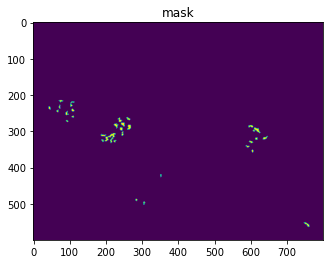

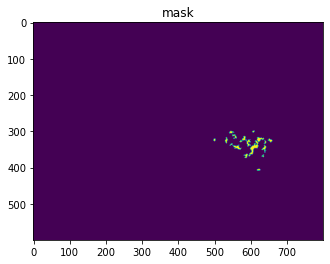

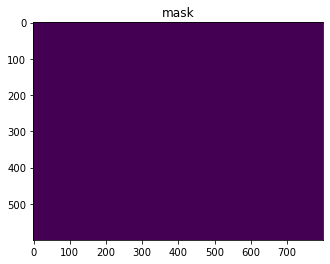

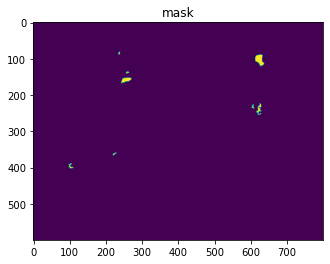

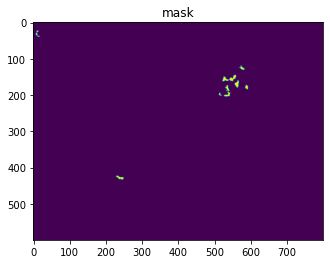

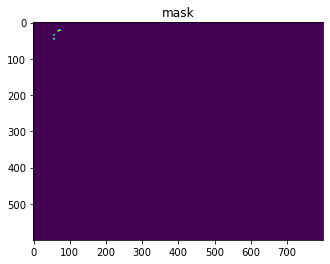

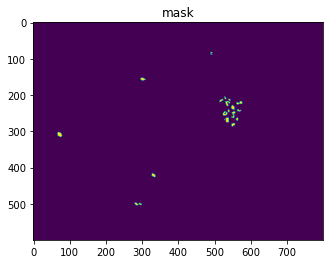

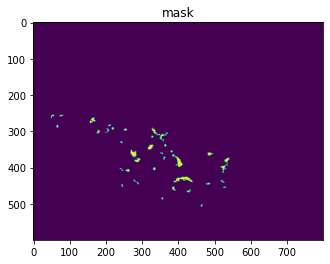

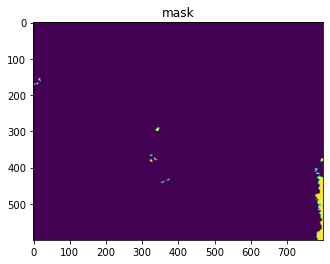

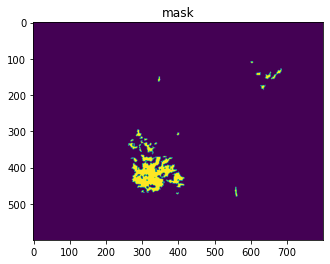

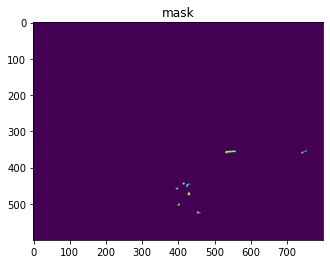

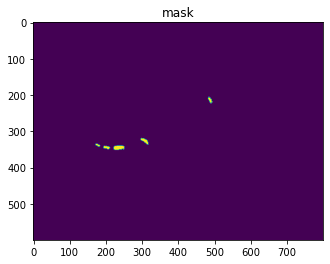

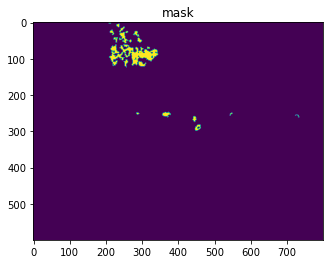

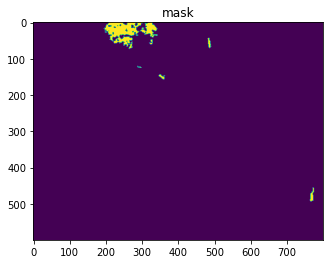

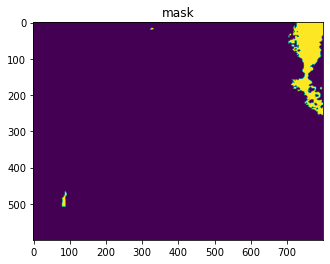

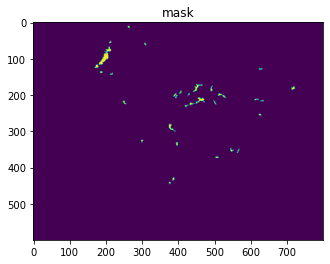

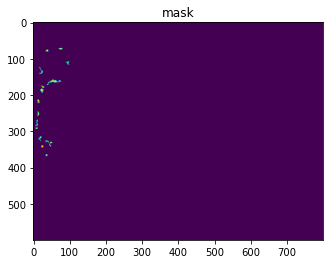

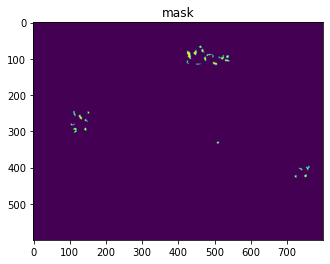

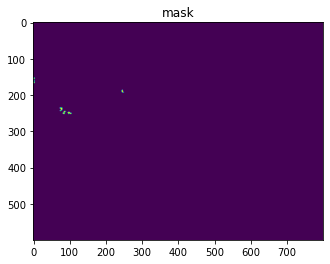

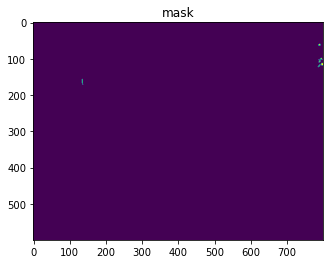

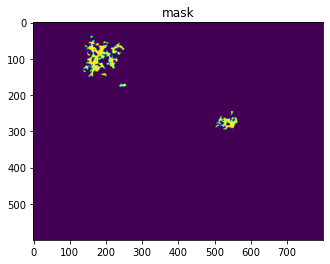

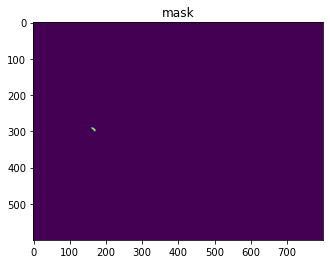

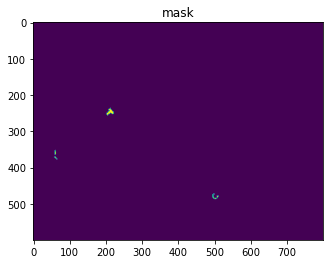

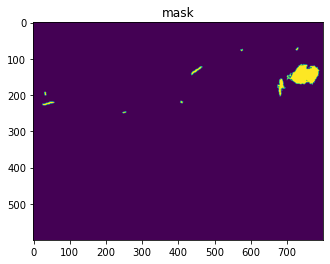

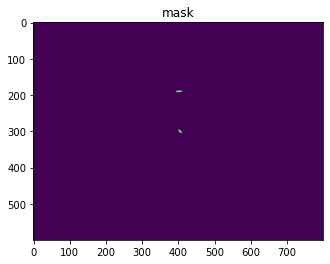

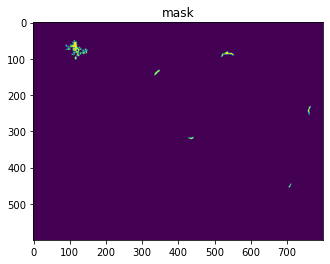

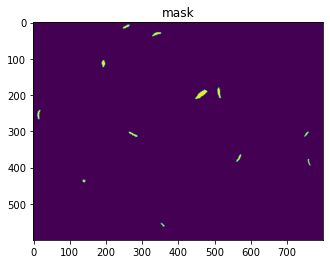

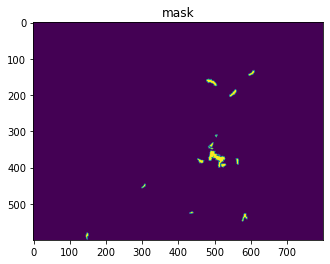

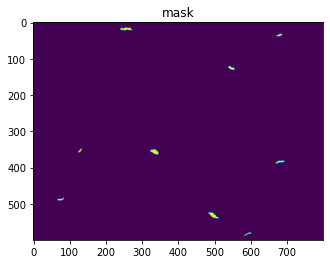

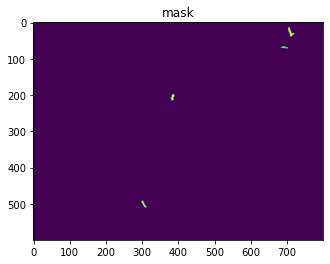

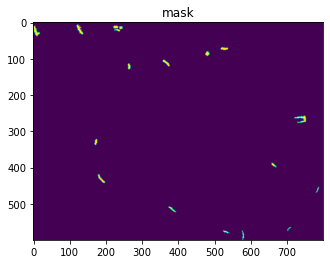

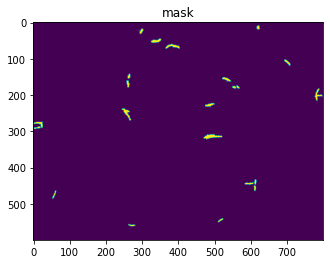

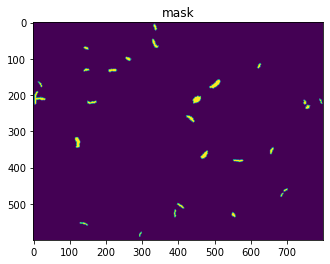

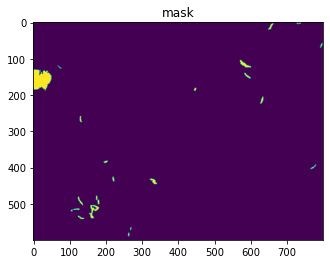

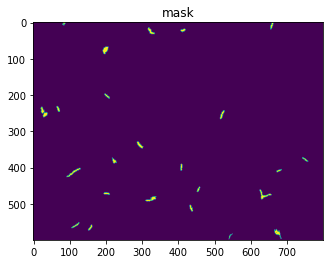

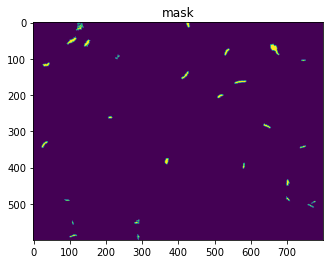

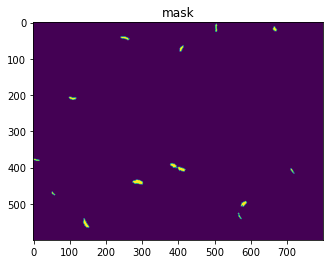

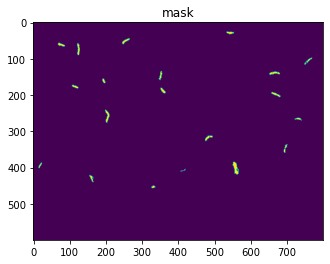

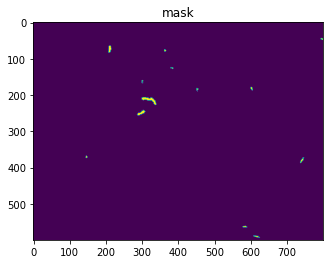

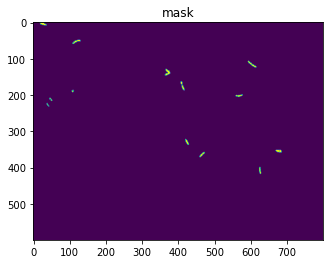

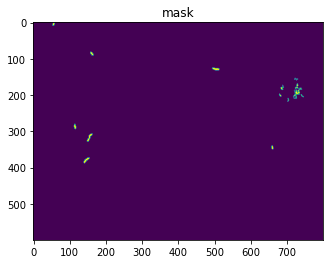

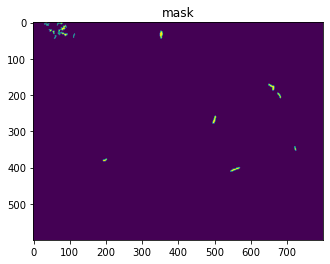

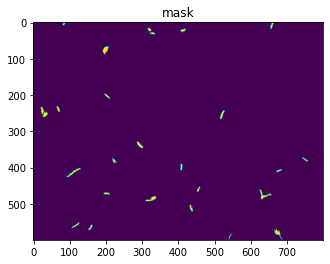

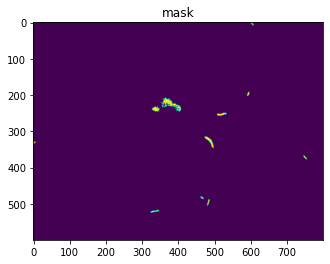

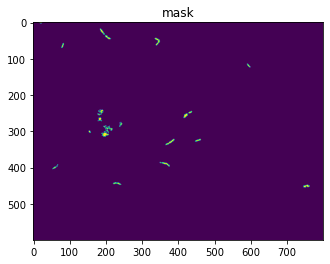

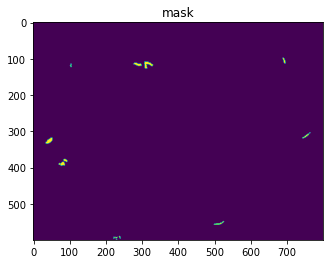

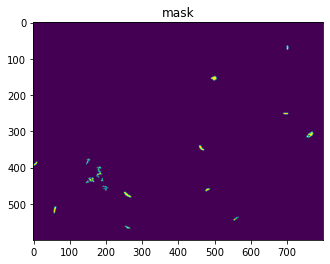

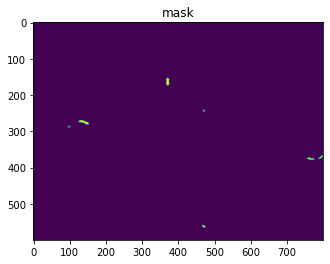

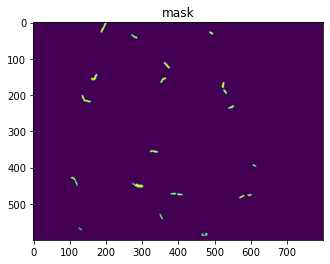

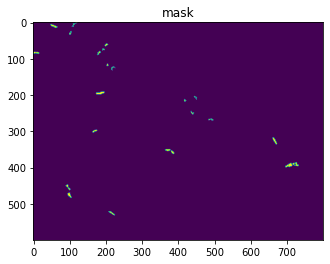

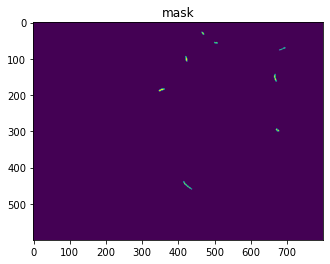

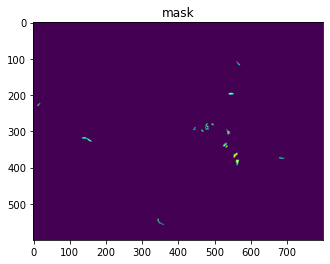

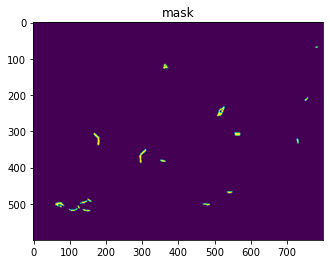

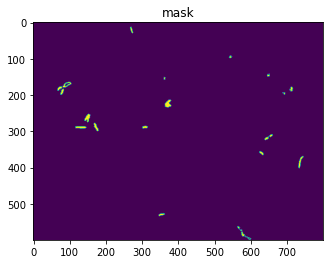

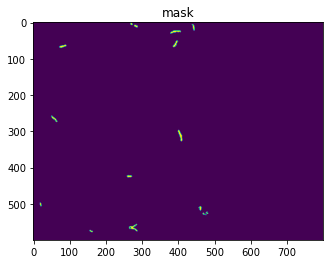

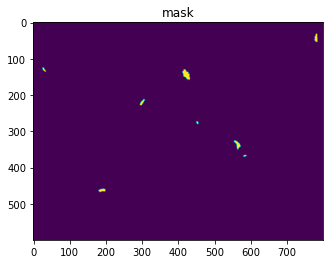

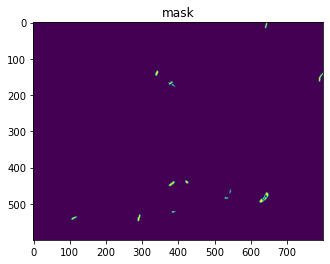

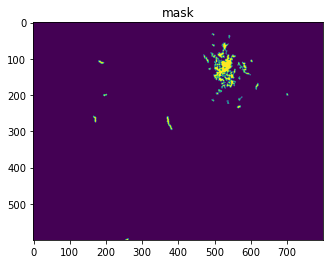

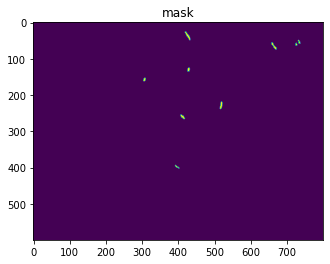

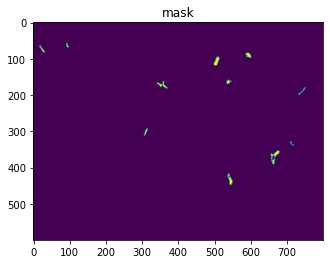

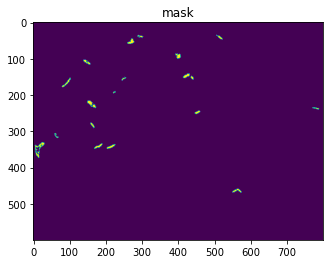

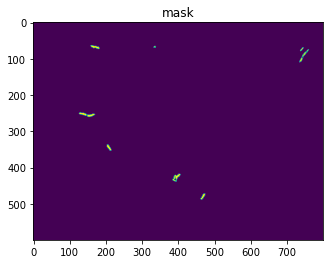

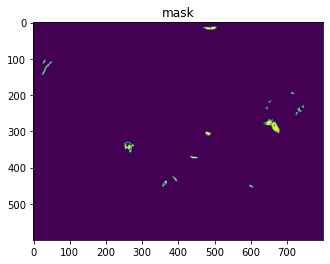

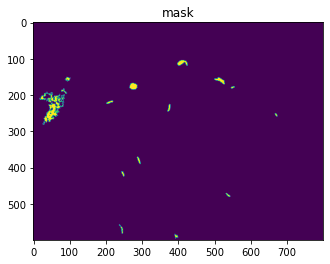

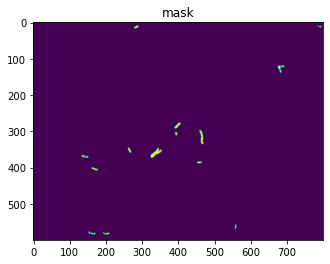

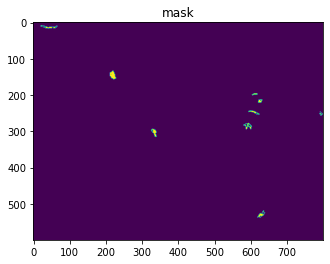

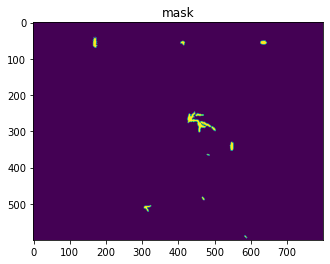

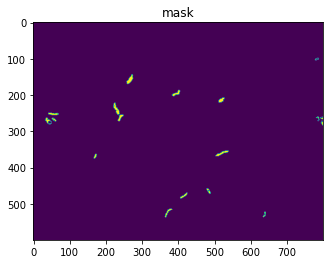

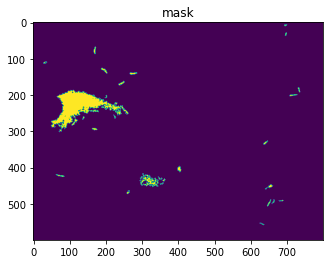

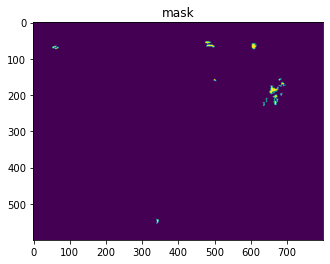

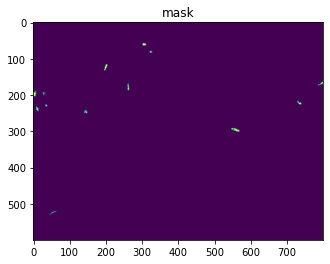

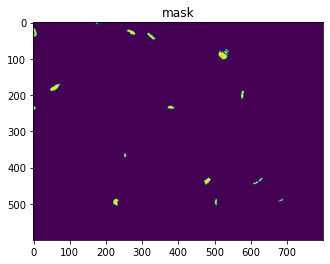

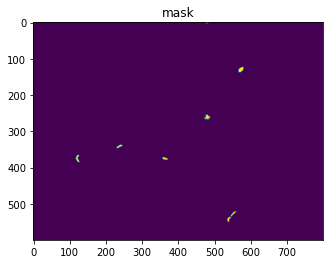

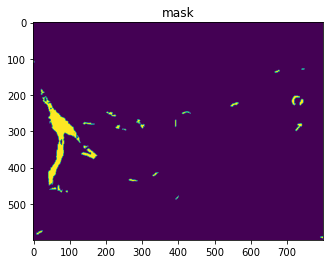

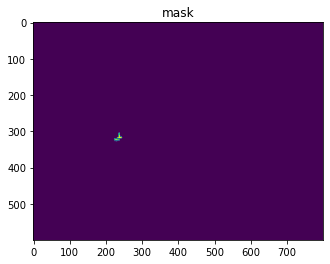

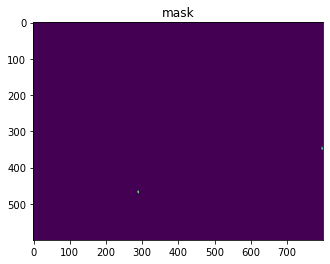

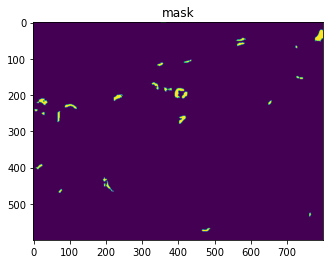

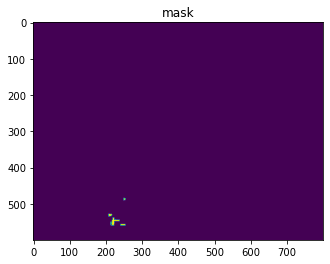

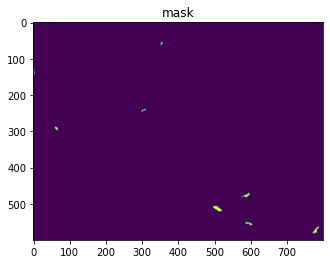

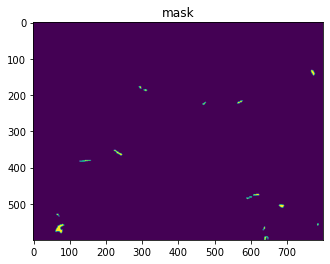

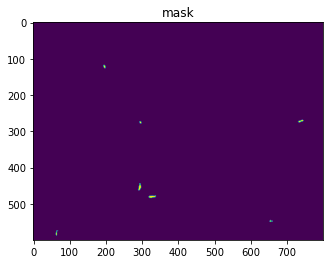

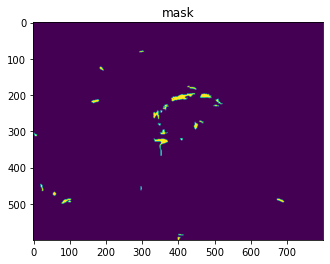

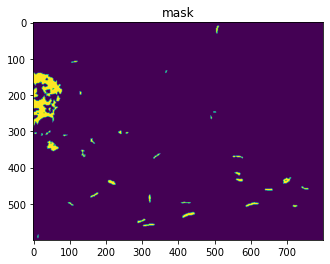

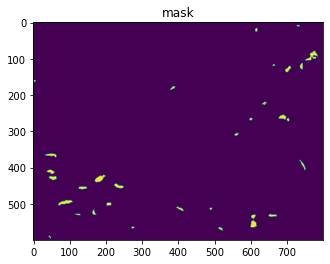

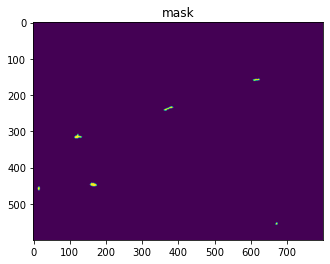

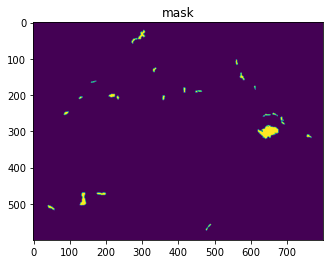

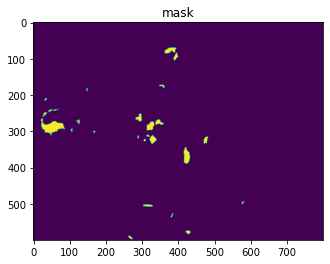

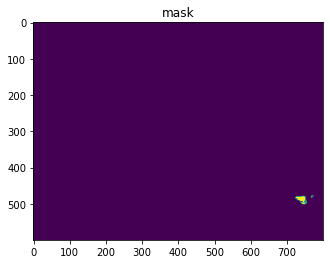

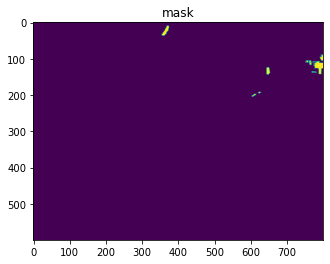

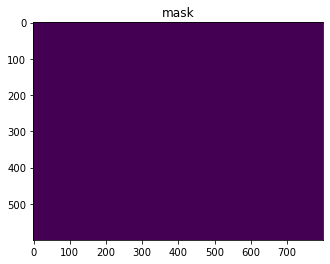

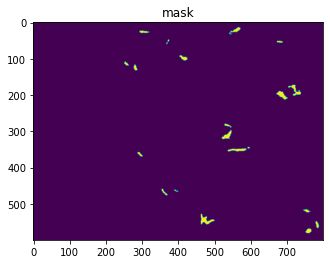

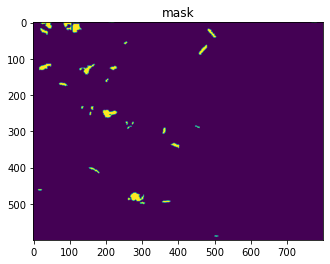

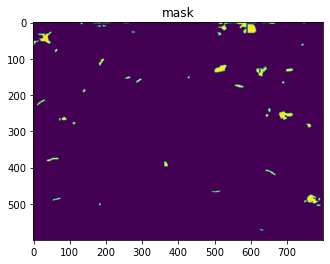

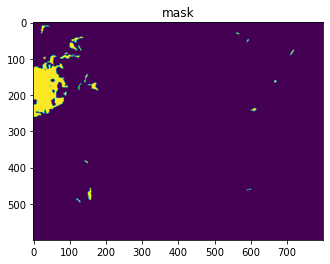

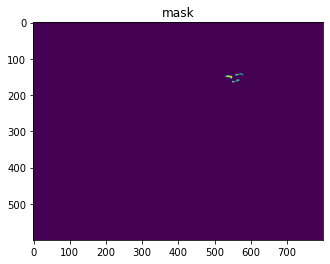

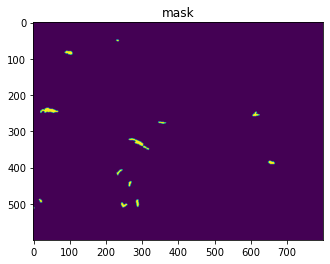

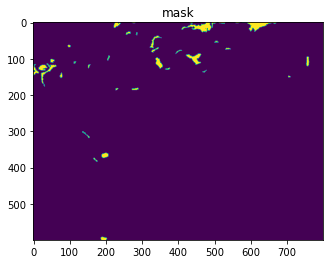

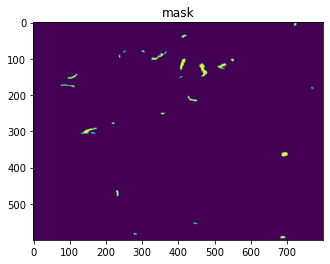

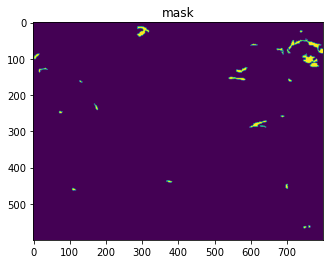

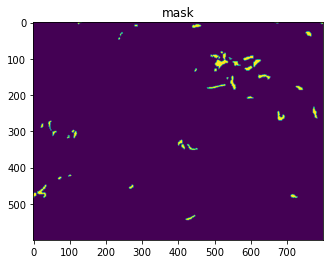

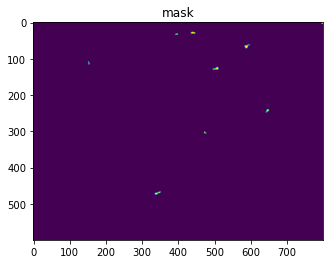

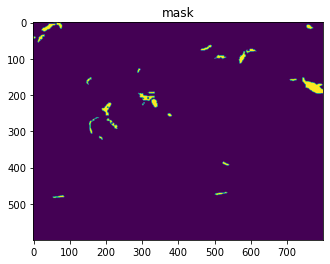

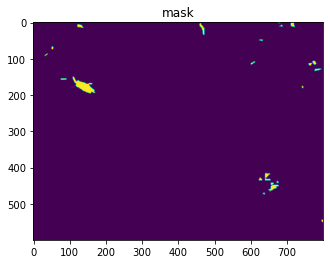

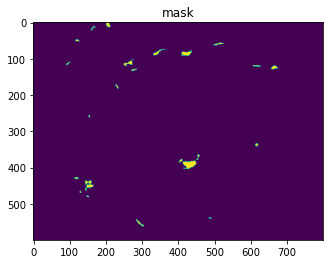

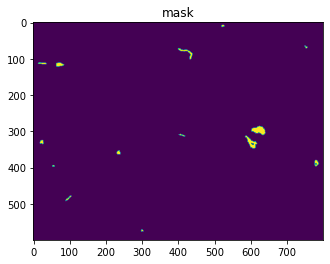

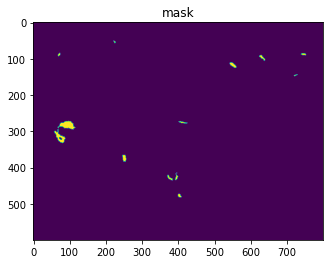

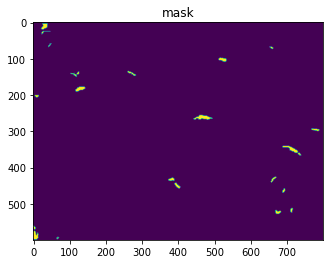

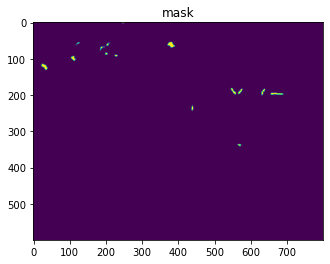

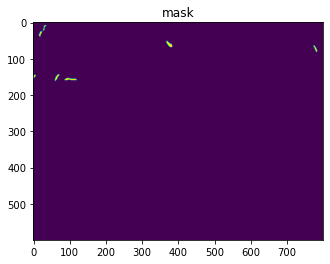

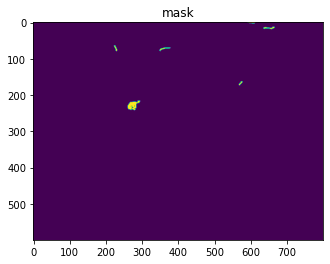

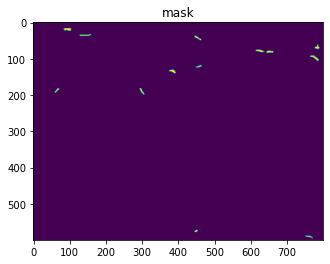

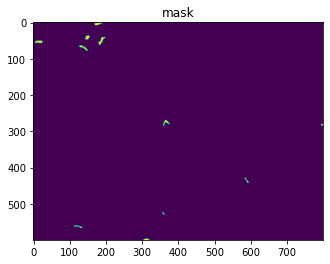

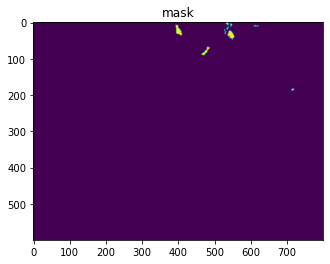

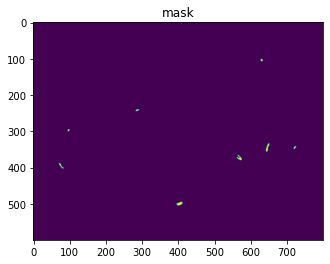

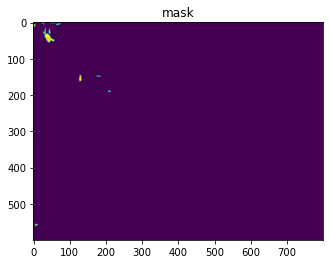

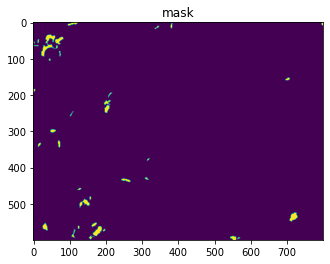

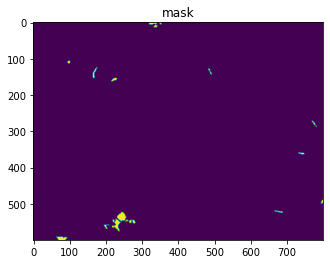

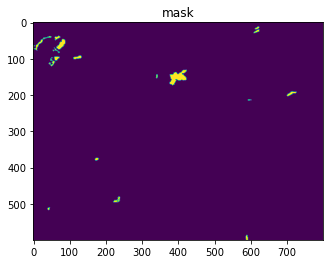

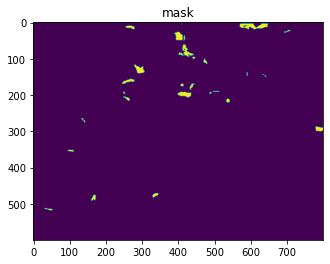

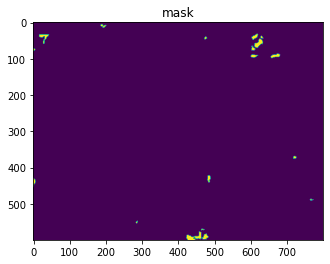

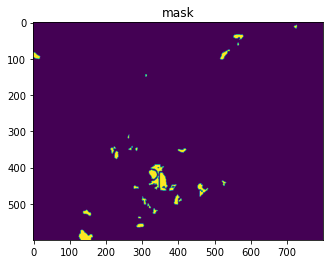

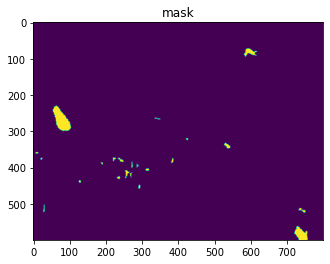

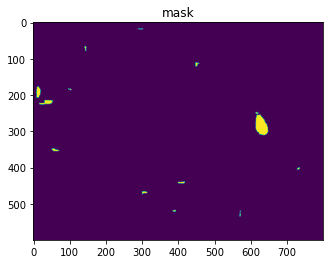

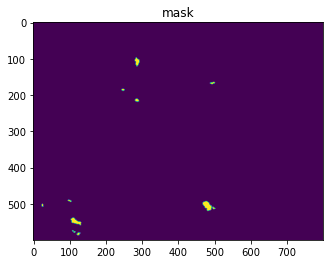

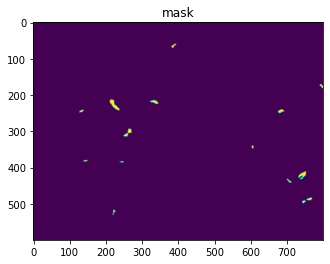

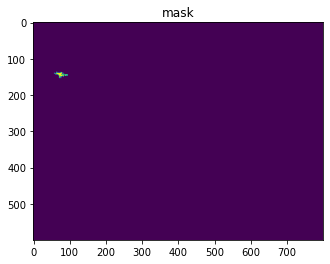

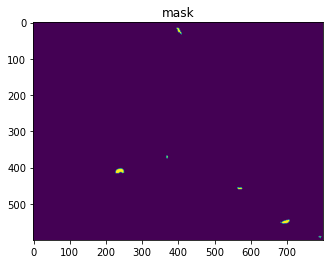

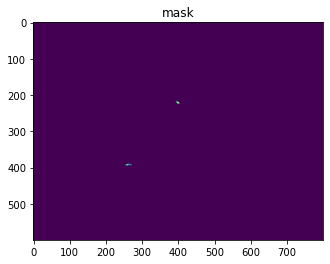

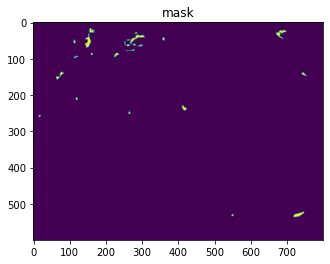

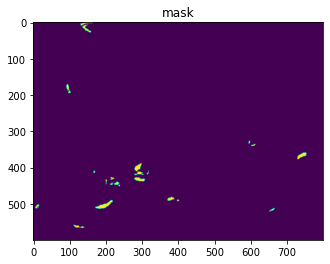

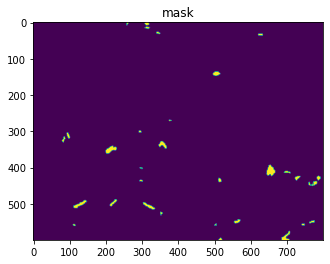

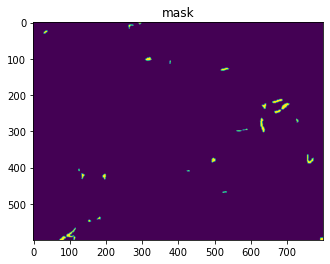

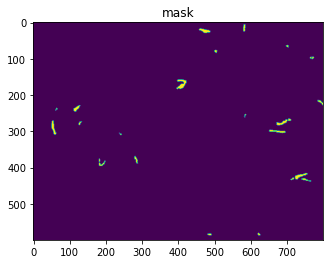

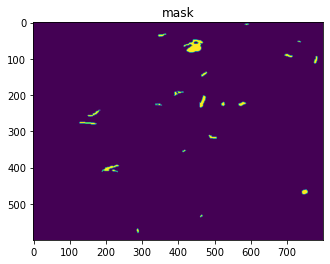

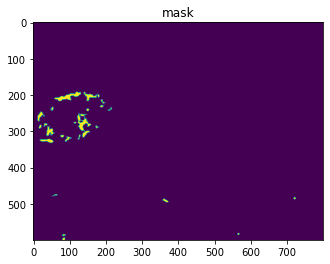

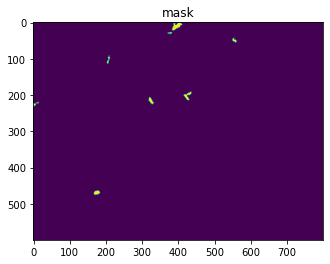

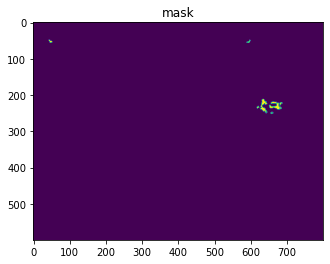

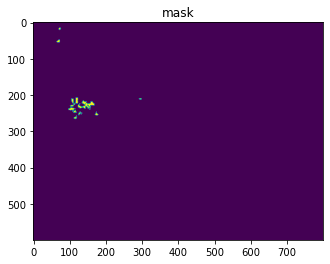

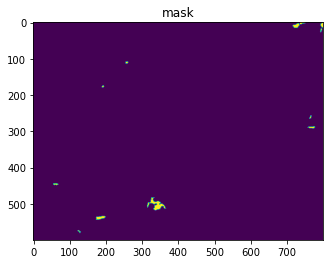

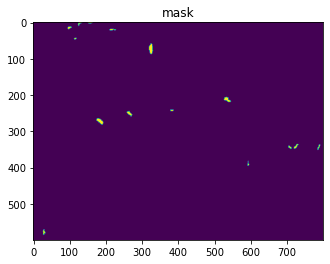

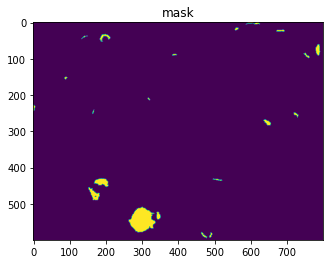

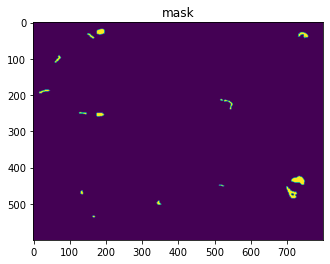

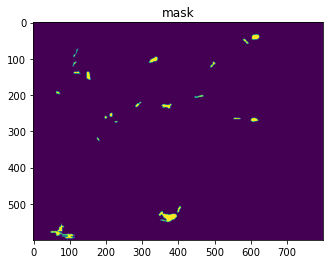

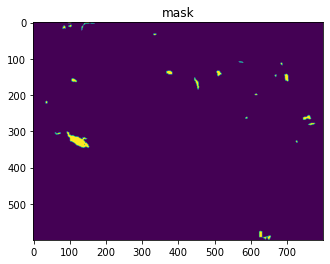

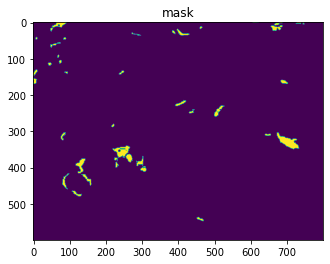

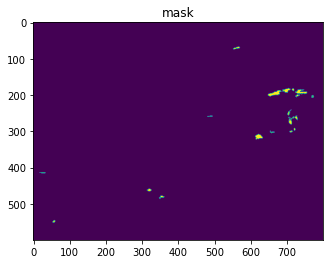

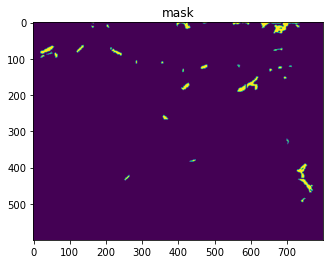

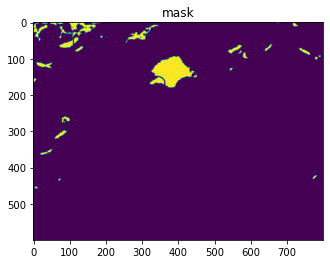

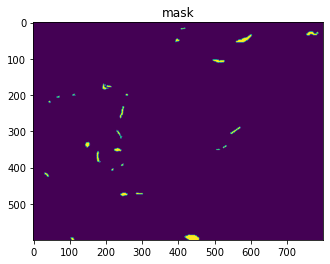

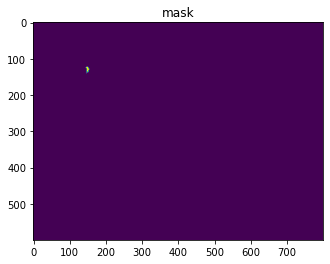

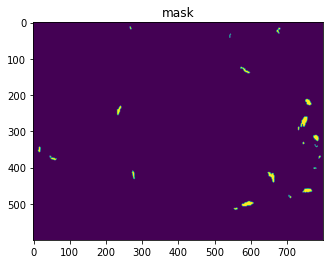

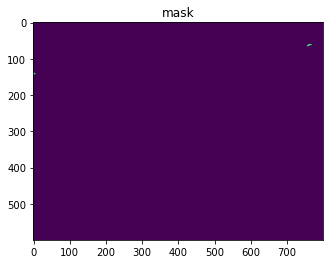

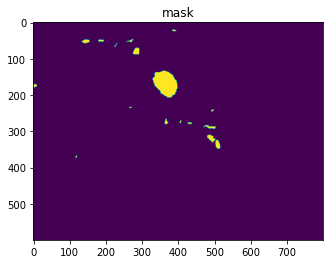

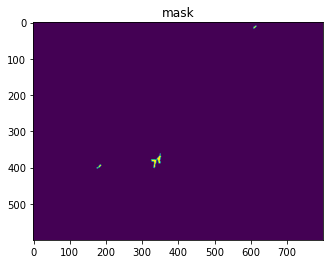

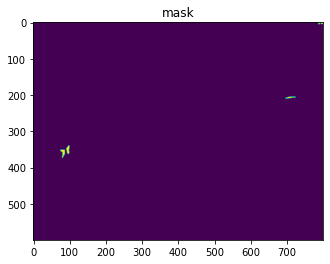

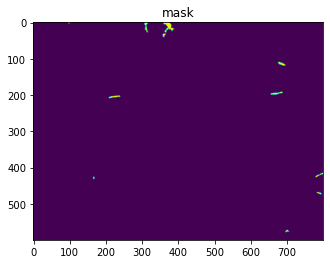

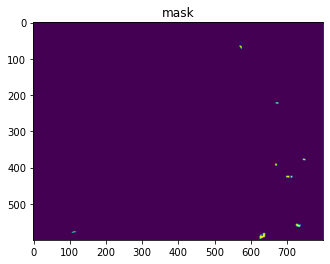

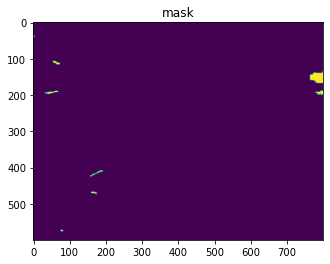

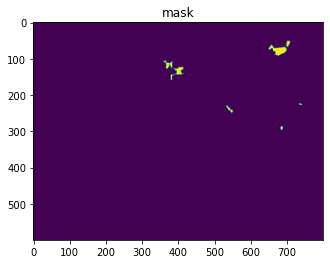

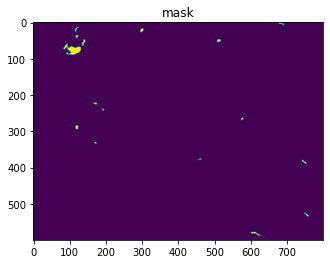

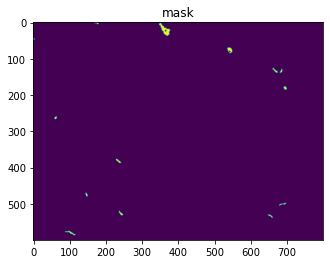

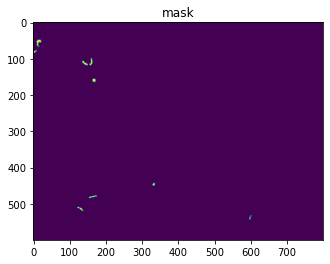

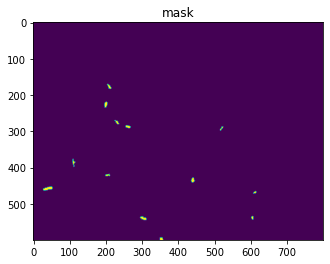

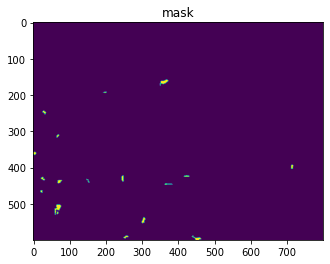

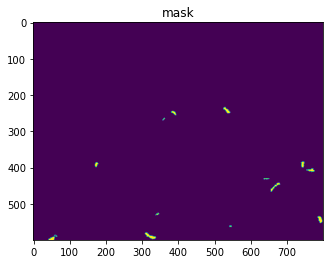

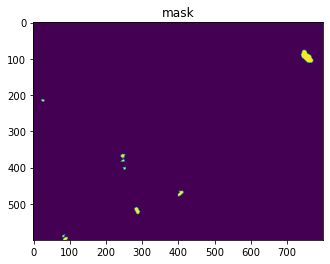

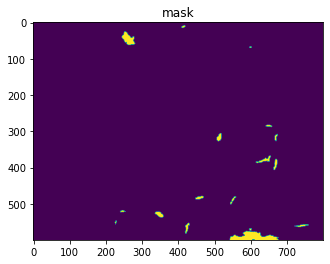

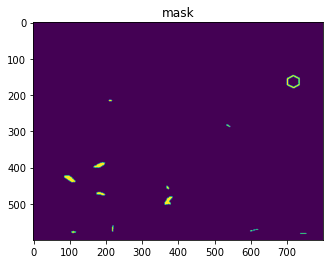

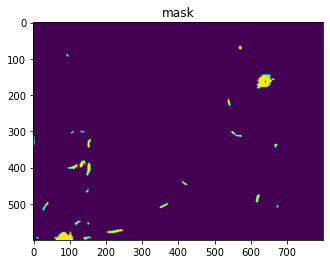

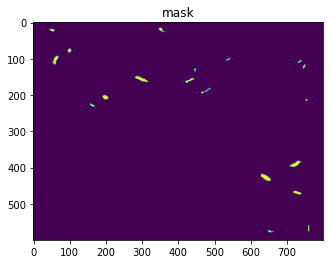

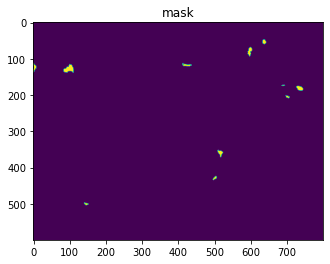

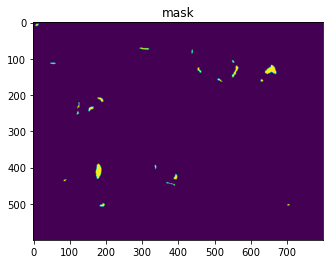

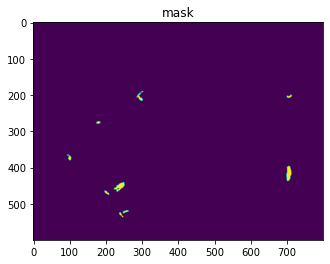

In [13]:
img_shape = (600,800)

# Iterating over each image of each image subfolder
for folder in folders:
    fold_path = os.path.join(main_fold,folder)
    img_fold_path = os.path.join(fold_path,"Images")
    annot_fold_path = os.path.join(fold_path,"Annotations")
    img_files = os.listdir(img_fold_path)
    
    for img_file in img_files:
        
        # Reading the input image 
        img_file_path = os.path.join(img_fold_path,img_file)
        orig_img = cv2.imread(img_file_path) 
        orig_img_shape = orig_img.shape[0:2] 
        img = orig_img.copy() 
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, img_th = cv2.threshold(img_gray,30,255,cv2.THRESH_BINARY_INV)
        img_th_inv = 255-img_th

               
        # Performing image segmentation on input image
        img_seg = image_segmentation(img)
        
        # Bitwise AND between segmented image and grayscale thresholded image to remove any bounding markers
        img_seg = cv2.bitwise_and(img_seg,img_th_inv)
        
        # Resizing the segmented image to standard size of 600x800 for further processing
        img_seg = cv2.resize(img_seg,(img_shape[1],img_shape[0]))
                
        
        # Post processing on the segmented image
        img_pp = image_postprocess(img_seg)
       
        
        # Assigning class labels to each object of the postprocessed image
        img_lbl,img_pp_lbl = label_image_objects(img_file,annot_fold_path)
                
        
        # Finding the contours of objects from the postprocessed labelled image
        contours_filt = find_contours(img_pp_lbl)
                                      
        # Extract the geometric features and get class labels of all the filtered contours
        for cnt in contours_filt:
            features = extract_features(cnt)
            cnt_centre,area,roughness,rel_conv_area,eccentricity,circularity,compactness,eccentricity = features
            cls_lbl = get_class_lbl(img_lbl,cnt_centre)
            
            # Append the features to input dataframe if class label is valid and form the data matrix
            if (cls_lbl):       
                data = data.append({'Area' : area,  'Roughness' : roughness, 'Relative convex area':rel_conv_area, 
                                    'Circularity':circularity, 'Compactness': compactness, 'Eccentricity':eccentricity, 
                                    'Class' : cls_lbl}, ignore_index = True)
                #print(data)
            
            # data = data.append({'Area' : area,  'Eccentricity' : eccentricity, 
                                # 'Class' : cls_lbl}, ignore_index = True)